In [1]:
import pandas as pd

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    if "google.colab" in sys.modules:
        !pip install -q pyomo
    else:
        !conda install -c conda-forge pyomo
    assert(shutil.which("pyomo"))
    
if not (shutil.which("glpsol") or os.path.isfile("glpsol")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq glpk-utils
    else:
        try:
            !conda install -c conda-forge glpk 
        except:
            pass
    assert(shutil.which("glpsol") or os.path.isfile("glpsol"))

import pyomo.environ as pe

# Blocs 1 & 2: données et paramètres d'entrée
Nous avons deux jeux de données différents (c.-à-d., deux problèmes) avec des structures similaires:
* Dans le problème #1, l'instance se compose de 3 fournisseurs, 2 produits (véhicules) et 4 scénarios. Il n'y a qu'une seule configuration de chaîne d'approvisionnement;
* Dans le problème #2, l'instance se compose de 5 fournisseurs, 8 produits (véhicules) et 21 scénarios. Il existe trois configurations de chaîne logistique (A, B et C) et l'analyse de chaque configuration doit être effectuée séparément (c.-à-d., avec des exécutions différentes).
Nous vous recommandons d'examiner le problème 1 pour voir la structure du modèle avant d'essayer le problème 2.

**Détails des données et paramètres d'entrée**

Le DataFrame `inputScenarios` contient les valeurs des liens actifs $\alpha_{ij}^n$ entre le noeud d'approvisionnement $i$ et le noeud de produit/véhicule $j$ dans le scénario $n$. En particulier, $\alpha_{ij}^n = 1$ indique que ce lien est actif dans ce scénario alors que $\alpha_{ij}^n = 0$ indique que le lien est inactif (perturbé) dans ce scénario.

De plus, le DataFrame `inputParameters` contient l'ensemble des paramètres suivants:
* La colonne *Type* indique si le paramètre concerne le noeud d'approvisionnement (Supplier), le noeud de produit (Product) ou est en lien avec le temps de récupération (Disruption);
* La colonne *Parameter* indique quel paramètre est donné sur cette ligne. Ces paramètres sont:
> * Capacité du noeud d'approvisionnement $i$: $c_i$
> * Demande du noeud de produit $j$: $d_j$
> * Stock initial du produit $j$: $s_j$
> * Bénéfice unitaire (marge bénéficiaire) du produit $j$: $f_j$
> * Temps de récupération (TTR) de chaque scénario $n$: $t^n$
* La colonne *Index* indique l'index associé à ce paramètre;
* La colonne *Value* indique la valeur de ce paramètre.

In [2]:
# Le paramètre SIZE doit être défini à 'small' ou 'large'
# Le paramètre CONFIGURATION doit être défini à 'A', 'B' ou 'C'
SIZE = 'small'
CONFIGURATION = 'A'

if SIZE == 'small':    
    # Problème 1 (petite échelle, une configuration)
    url = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/data/predictedSales_Prob1.csv'

    pathParameters = 'data/inputParameters_Prob1.csv'
    pathScenarios  = 'data/inputScenarios_Prob1.csv'
elif SIZE == 'large':    
    # Problème 2 (grande échelle, 3 configurations possibles: A, B et C)
    pathParameters = 'data/inputParameters_Prob2.csv'
    # Voici les scénarios sous chaque configuration. 
    # L'analyse peut seulement être effectuée pour une configuration à la fois, choisissez donc un seul fichier.
    if CONFIGURATION == 'A':
        pathScenarios  = 'data/inputScenarios_Prob2_Config_A.csv'
    elif CONFIGURATION == 'B':
        pathScenarios  = 'data/inputScenarios_Prob2_Config_B.csv'
    elif CONFIGURATION == 'C':
        pathScenarios  = 'data/inputScenarios_Prob2_Config_C.csv'
    else:   
        raise ValueError("CONFIGURATION doit être défini à 'A', 'B' ou 'C'")
else:
    raise ValueError("SIZE doit être défini à 'small' ou 'large'")
    
# Lecture des fichiers CSV
inputScenarios = pd.read_csv(pathScenarios)
inputParameters = pd.read_csv(pathParameters)

print("inputScenarios:")
display(inputScenarios)
print("\ninputParameters:")
display(inputParameters)

inputScenarios:


,Node,Product,Scenario_0,Scenario_1,Scenario_2,Scenario_3
0,S1,P1,1,0,1,1
1,S1,P2,1,0,1,1
2,S2,P1,1,1,0,1
3,S2,P2,1,1,0,1
4,S3,P1,1,1,1,0
5,S3,P2,1,1,1,0



inputParameters:


,Type,Parameter,Index,Value
0,Supplier,Capacity,S1,30
1,Supplier,Capacity,S2,45
2,Supplier,Capacity,S3,60
3,Product,Demand,P1,75
4,Product,Demand,P2,50
5,Product,Inventory,P1,20
6,Product,Inventory,P2,25
7,Product,Loss,P1,5000
8,Product,Loss,P2,6500
9,Disruption,TTR,Scenario_0,2


Nous créons ensuite les entrées utilisées dans le modèle Pyomo à partir des DataFrames ci-dessus.

**Listes**: 
*   `supplierList` contient la liste des noeuds d'approvisionnement (usines), correspond à l'ensemble $A \ni i$;
*   `productList` contient la liste des noeuds de produits (véhicules), correspond à l'ensemble $V \ni j$;
*   `scenarioList` contient la liste des scénarios.

**Dictionnaires de données**:
*  `supplierCapacityDict[i]` contient les valeurs de $c_i$;
*  `productDemandDict[j]` contient les valeurs de $d_j$;
*  `productInvDict[j]` contient les valeurs de $s_j$;
*  `productLossDict[j]` contient les valeurs de $f_j$;
*  `scenarioTTRDict[n]` contient les valeurs de $t^n$;
*  `scenarioActiveNodeDict[n][i, j]` contient les valeurs de $\alpha^n_{ij}$.

In [3]:
supplierList = inputParameters.loc[inputParameters['Type'] == 'Supplier', 'Index'].unique()
productList = inputParameters.loc[inputParameters['Type'] == 'Product', 'Index'].unique()
scenarioList = inputParameters.loc[inputParameters['Type'] == 'Disruption', 'Index'].unique()
print(f"supplierList: {supplierList}")
print(f"productList: {productList}")
print(f"scenarioList: {scenarioList}")

supplierCapacityDict = {}
for i in supplierList:
    mask = (inputParameters['Parameter'] == 'Capacity') & (inputParameters['Index'] == i)
    supplierCapacityDict[i] = inputParameters.loc[mask, 'Value'].values[0]
print(f'supplierCapacityDict: {supplierCapacityDict}')

productDemandDict = {}
productInvDict = {}
productLossDict = {}
for j in productList:
    mask_index = inputParameters['Index'] == j
    dem = inputParameters.loc[(inputParameters['Parameter'] == 'Demand') & mask_index, 'Value'].values[0]
    inv = inputParameters.loc[(inputParameters['Parameter'] == 'Inventory') & mask_index, 'Value'].values[0]
    loss = inputParameters.loc[(inputParameters['Parameter'] == 'Loss') & mask_index, 'Value'].values[0]
    productDemandDict[j] = dem
    productInvDict[j] = inv
    productLossDict[j] = loss
print(f'productDemandDict: {productDemandDict}')
print(f'productInvDict: {productInvDict}')
print(f'productLossDict: {productLossDict}')

scenarioTTRDict = {}
for n in scenarioList:
    mask = (inputParameters['Parameter'] == 'TTR') & (inputParameters['Index'] == n)
    scenarioTTRDict[n] = inputParameters.loc[mask, 'Value'].values[0]
print(f'scenarioTTRDict: {scenarioTTRDict}\n')

scenarioActiveNodeDict = {}
for n in scenarioList:
    scenarioActiveNodeDict[n] = {}
    avgNActiveLinks = sum(inputScenarios[n].values) / len(supplierList)
    print(f"Nombre moyen de liens par usine pour {n}: {avgNActiveLinks:.2f}")
    for row in inputScenarios.itertuples():  # chaque ligne du DataFrame nous est retournée comme un namedtuple
        supp = row.Node  # on extrait l'élément Node de la ligne
        prod = row.Product  # on extrait l'élément Product de la ligne
        scenarioActiveNodeDict[n][supp, prod] = getattr(row, n)  # on extrait la colonne défini dans n de la ligne
for key in scenarioActiveNodeDict:
    print(f'scenarioActiveNodeDict[{key}]: {scenarioActiveNodeDict[key]}')

supplierList: ['S1' 'S2' 'S3']
productList: ['P1' 'P2']
scenarioList: ['Scenario_0' 'Scenario_1' 'Scenario_2' 'Scenario_3']
supplierCapacityDict: {'S1': 30, 'S2': 45, 'S3': 60}
productDemandDict: {'P1': 75, 'P2': 50}
productInvDict: {'P1': 20, 'P2': 25}
productLossDict: {'P1': 5000, 'P2': 6500}
scenarioTTRDict: {'Scenario_0': 2, 'Scenario_1': 2, 'Scenario_2': 2, 'Scenario_3': 2}

Nombre moyen de liens par usine pour Scenario_0: 2.00
Nombre moyen de liens par usine pour Scenario_1: 1.33
Nombre moyen de liens par usine pour Scenario_2: 1.33
Nombre moyen de liens par usine pour Scenario_3: 1.33
scenarioActiveNodeDict[Scenario_0]: {('S1', 'P1'): 1, ('S1', 'P2'): 1, ('S2', 'P1'): 1, ('S2', 'P2'): 1, ('S3', 'P1'): 1, ('S3', 'P2'): 1}
scenarioActiveNodeDict[Scenario_1]: {('S1', 'P1'): 0, ('S1', 'P2'): 0, ('S2', 'P1'): 1, ('S2', 'P2'): 1, ('S3', 'P1'): 1, ('S3', 'P2'): 1}
scenarioActiveNodeDict[Scenario_2]: {('S1', 'P1'): 1, ('S1', 'P2'): 1, ('S2', 'P1'): 0, ('S2', 'P2'): 0, ('S3', 'P1'): 1, (

# Blocs 3 & 4: modèles d'optimisation et résultats
Étant donné que le cadre d'analyse de l'exposition au risque nécessite de résoudre un programme linéaire (PL) pour chaque scénario, nous utilisons une boucle *for* sur chaque scénario $n$ qui permet (1) de créer un PL avec les paramètres appropriés et (2) de résoudre le modèle pour obtenir la solution optimale qui correspond à ce scénario. Il existe deux modèles d'optimisation, à savoir les modèles TTR et TTS.

## Bloc 3A: modèle TTR
Le modèle TTR permet de déterminer le plan d'urgence post-perturbation. Les composantes du modèle sont les suivantes (notez que ces variables sont créées pour chaque scénario mais que l'index de scénario $n$ est supprimé):

(i) **Variables de décision:**
*   `model.l[j]` ($l_{j}^n$): la demande perdue pour le produit $j$;
*   `model.y[i, j]` ($y_{ij}^n$): la quantité de produit $j$ produite chez le fournisseur $i$;

(ii) **Fonction objectif:** 

Dans le modèle TTR, nous voulons minimiser la perte de profit totale due à la perturbation dans chaque scénario, c.-à-d.,
$$\text{minimiser}_{y,l} \sum_{j \in V} f_j \cdot l_j^n$$

(iii) **Contraintes:**

**Contraintes 1:**  demande perdue pour le produit $j$

Cet ensemble de contraintes permet de déterminer la limite inférieure de la demande perdue ($l_j^n$) pendant le temps de perturbation ($t^{n}$) étant donné le niveau de stock actuel ($s_j$), et la production du produit $j$ par le fournisseur $i$ ($y_{ij}^n$) (si la production est possible, c.-à-d., si $\alpha^{n}_{ij} = 1$):
$$\sum_{i\in A} \alpha^{n}_{ij} y^n_{ij} + l_j^n \geq d_j t^{n} - s_j,\quad \forall j\in V $$

**Contraintes 2:**  capacité chez chaque fournisseur $i$

Cet ensemble de contraintes garantit que la production cumulée chez le fournisseur $i$ est inférieure ou égale à la capacité de ce fournisseur s'il est toujours actif ($\alpha^{n}_{ij} = 1$). Notez que nous devons vérifier si au moins un lien $\alpha^{n}_{ij}$ pour le fournisseur $i$ est actif pour ce scénario, sinon Pyomo renverra une erreur. Dans le cas où il n'y a pas de lien actif, nous omettons ce fournisseur dans le modèle (puisque ce fournisseur ne sera pas utilisé de toute façon). Ceci est fait dans le code lorsque nous utilisons le booléen *noSupply*.
$$\sum_{j\in V} \alpha^{n}_{ij} y_{ij}^n  \leq c_i t^{n},\quad \forall i\in A$$

## Bloc 4A: solution et interprétation
Pour agréger les résultats de chaque scénario, nous calculons et stockons les résultats dans le DataFrame `scenarioResults` qui stocke les résultats suivants en fonction de la solution optimale $\left( \mathbf{l}^{n,*}, \mathbf{y}^{n,*} \right)$ pour chaque scénario $n$ : 
* `'disruptionCost'` $\left( \sum_j f_j \cdot l_j^{n,*} \right)$: coût de la perturbation, 
* `'riskExposureIndex'` $\left( \frac{C^n}{C^{\max}} \right)$: indice de risque pour le scénario, 
* `'lostUnits'` $\left( \sum_j l_j^{n,*} \right)$: demande totale perdue durant la perturbation, 
* `'totalProduction'` $\left( \sum_i \sum_j \alpha^{n}_{ij} \cdot y_{ij}^{n,*} \right)$: production totale durant la perturbation, 
* `'disruptedLinks'` $\left( \sum_i\sum_j \left(1-\alpha^{n}_{ij}\right) \right)$: nombre de liens perturbés, et 
* `'usedLinks'` $\left( \sum_i\sum_j \mathbb{1}\{y^{n,*}_{ij} > 0\} \right)$: nombre de liens utilisés lors de la perturbation.

Enfin, nous affichons les statistiques descriptives des résultats de tous les scénarios de perturbation. Ici, nous utilisons les méthodes `describe()` et `hist()` de pandas.

,disruptionCost,riskExposureIndex,lostUnits,totalProduction,disruptedLinks,usedLinks
Scenario_0,0.0,0.00,0.0,205.0,0.0,4.0
Scenario_1,0.0,0.00,0.0,205.0,2.0,3.0
Scenario_2,125000.0,0.45,25.0,180.0,2.0,3.0
Scenario_3,275000.0,1.00,55.0,150.0,2.0,3.0


,disruptionCost,riskExposureIndex,lostUnits,totalProduction,disruptedLinks,usedLinks
count,4.00,4.00,4.00,4.00,4.0,4.00
mean,100000.00,0.36,20.00,185.00,1.5,3.25
std,130703.23,0.48,26.14,26.14,1.0,0.50
min,0.00,0.00,0.00,150.00,0.0,3.00
10%,0.00,0.00,0.00,159.00,0.6,3.00
50%,62500.00,0.23,12.50,192.50,2.0,3.00
90%,230000.00,0.84,46.00,205.00,2.0,3.70
max,275000.00,1.00,55.00,205.00,2.0,4.00


<AxesSubplot:>

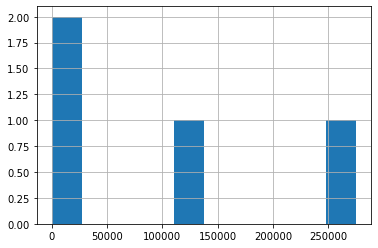

In [4]:
# Modèle TTR
disruptionResponse = {}  # pour stocker la variable y
disruptionDemandLoss = {}  # pour stocker la variable l

resultcolumns = ['disruptionCost', 'riskExposureIndex', 'lostUnits', 'totalProduction', 'disruptedLinks', 'usedLinks']
scenarioResults = pd.DataFrame(columns=resultcolumns, index=scenarioList)

for n in scenarioList:
    model = pe.ConcreteModel()

    # Variables
    model.l = pe.Var(productList, within=pe.NonNegativeReals)
    model.y = pe.Var(supplierList, productList, within=pe.NonNegativeReals)

    # Fonction objectif
    obj_expr = sum(productLossDict[j] * model.l[j] for j in productList)
    model.obj = pe.Objective(expr=obj_expr, sense=pe.minimize)

    # Contraintes 1 calcule la perte de demande pour chaque produit
    model.demandLoss = pe.ConstraintList()
    for j in productList:
        const_expr = (sum(scenarioActiveNodeDict[n][i, j] * model.y[i, j] 
                          for i in supplierList) + model.l[j] >= 
                      productDemandDict[j] * scenarioTTRDict[n] - productInvDict[j]) 
        model.demandLoss.add(expr=const_expr)

    # Contraintes 2 capacité chez chaque fournisseur i
    model.supplierCapacity = pe.ConstraintList()
    for i in supplierList:
        noSupply = True
        for j in productList:
            if scenarioActiveNodeDict[n][i, j] > 0: 
                noSupply = False  # a trouvé un lien actif pour ce fournisseur
                break
        # nous générons la contrainte uniquement si noSupply = False
        if not noSupply:
            const_expr = sum(scenarioActiveNodeDict[n][i, j] * model.y[i, j] 
                             for j in productList) <= supplierCapacityDict[i] * scenarioTTRDict[n]
            model.supplierCapacity.add(expr=const_expr)

    # Résolution du modèle
    pe.SolverFactory('glpk').solve(model) 

    # Sauvegarde du résultat pour chaque scénario
    scenarioResults.loc[n, 'disruptionCost'] = model.obj()

    disruptionDemandLoss[n] = {}
    for j in productList:
        disruptionDemandLoss[n][j] = model.l[j].value
    scenarioResults.loc[n, 'lostUnits'] = sum(disruptionDemandLoss[n].values())  # somme de toutes les valeurs du dict

    disruptionResponse[n] = {}
    nUsedLinks = 0.
    for row in inputScenarios.itertuples():
        i = row.Node
        j = row.Product
        if scenarioActiveNodeDict[n][i, j] == 1:  # si alpha=1 pour ce lien
            disruptionResponse[n][i, j] = model.y[i, j].value  # extraire la valeur de y
            if model.y[i, j].value > 0.001:
                nUsedLinks += 1  # si cette valeur de y est positive, comptez ce lien comme utilisé
        else: 
            disruptionResponse[n][i, j] = 0.  # sinon mettre 0 comme valeur de y
    scenarioResults.loc[n, 'totalProduction'] = sum(disruptionResponse[n].values())
    scenarioResults.loc[n, 'disruptedLinks'] = inputScenarios.shape[0] - sum(scenarioActiveNodeDict[n].values())
    scenarioResults.loc[n, 'usedLinks'] = nUsedLinks

# Après avoir résolu tous les scénarios...
if scenarioResults['disruptionCost'].max() > 0.001:  # si au moins un scénario résulte en des pertes
    scenarioResults['riskExposureIndex'] = scenarioResults['disruptionCost'] / scenarioResults['disruptionCost'].max()
else: # sinon, on évite une division par zéro
    scenarioResults['riskExposureIndex'] = 0.
    
# Interprétation et affichage des résultats
scenarioResults = scenarioResults.astype(float)  # pour un meilleur affichage des résultats
#for n in scenarioList:  # pour afficher les décisions y
#    print(f"{n}: {disruptionResponse[n]}")
with pd.option_context('precision', 2):  # permet de changer l'affichage des décimales
    display(scenarioResults)
    display(scenarioResults.describe(percentiles=[.10, .90]))
scenarioResults['disruptionCost'].hist()

## Bloc 3B: modèle TTS
Le deuxième modèle est le modèle du temps de survie (TTS) qui détermine combien de temps peut s'écouler après une perturbation avant que de la demande soit perdue. Les composantes du modèle sont les suivantes:

(i) **Variables de décision:**
*   `model.t[0]` (ou $t^{n}$): temps de survie (TTS) pour le scénario $n$
*   `model.y[i, j]` (ou $y_{ij}^n$): la quantité de produit $j$ produite chez le fournisseur $i$;

(ii) **Fonction objectif:** Dans le modèle TTS, nous voulons maximiser le TTS dans chaque scénario, c.-à-d.,
$$\text{maximiser}_{y,t} t^n$$

(iii) **Contraintes:**

**Contraintes 1:**  la demande du produit $j$ doit être satisfaite sans perte

Cette contrainte permet de déterminer combien de temps la demande peut être pleinement satisfaite sans perte ($t^{n}$) compte tenu du niveau de stock actuel ($s_j$) et de la production pour le produit $j$ par le fournisseur $i$ ($y_{ij}^n$) (si la production est possible, c.-à-d., si $\alpha^{n}_{ij}=1$):
$$\sum_{i\in A} \alpha^{n}_{ij} y_{ij}^n \geq d_j t^{n} - s_j,\quad \forall j\in V $$

**Contraintes 2:**  capacité chez chaque fournisseur $i$

Cet ensemble de contraintes garantit que la production cumulée chez fournisseur $i$ est inférieure ou égale à la capacité de ce fournisseur s'il est toujours actif ($\alpha^{n}_{ij} = 1$). Notez que nous ne devons plus vérifier si au moins un lien $\alpha^{n}_{ij}$ pour le fournisseur $i$ est actif pour ce scénario, car la variable $t^{n}$ sera présente dans toutes les contraintes et elle sera toujours précédée d'un coefficient différent de 0.
$$\sum_{j\in V} \alpha^{n}_{ij} y_{ij}^n  \leq c_i t^{n},\quad \forall i\in A$$

## Bloc 4B: solution et interprétation
Pour agréger les résultats de chaque scénario, nous calculons et stockons les résultats dans le DataFrame `scenarioResults` qui stocke les résultats suivants en fonction de la solution optimale $\left( t^{n,*}, \mathbf{y}^{n,*} \right)$ pour chaque scénario $n$: 
* `'TTS'` $(t^{n,*})$: temps de survie,
* `'TTR'`: temps de perturbation utilisé dans le modèle TTR,
* `'totalProduction'` $\left( \sum_i \sum_j \alpha^{n}_{ij} y_{ij}^{n,*} \right)$: production totale durant la survie, 
* `'disruptedLinks'` $\left( \sum_i \sum_j \left(1-\alpha^{n}_{ij}\right) \right)$: nombre de liens perturbés, et 
* `'usedLinks'` $\left( \sum_i\sum_j \mathbb{1}\{y^{n,*}_{ij} > 0\} \right)$: nombre de liens utilisés lors de la survie.

Enfin, nous affichons les statistiques descriptives des résultats de tous les scénarios de perturbation. Ici, nous utilisons les méthodes `describe()` et `hist()` de pandas.

,TTS,TTR,totalProduction,disruptedLinks,usedLinks
Scenario_0,99.00,2.0,12330.00,0.0,4.0
Scenario_1,2.25,2.0,236.25,2.0,3.0
Scenario_2,1.29,2.0,115.71,2.0,3.0
Scenario_3,0.90,2.0,67.50,2.0,3.0


,TTS,TTR,totalProduction,disruptedLinks,usedLinks
count,4.00,4.0,4.00,4.0,4.00
mean,25.86,2.0,3187.37,1.5,3.25
std,48.76,0.0,6095.50,1.0,0.50
min,0.90,2.0,67.50,0.0,3.00
10%,1.02,2.0,81.96,0.6,3.00
50%,1.77,2.0,175.98,2.0,3.00
90%,69.98,2.0,8701.88,2.0,3.70
max,99.00,2.0,12330.00,2.0,4.00


<AxesSubplot:>

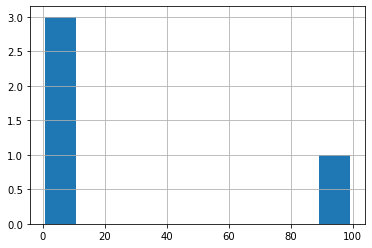

In [5]:
# Modèle TTS  
disruptionDemandLoss = {}

resultcolumns = ['TTS', 'TTR', 'totalProduction', 'disruptedLinks','usedLinks']
scenarioResults = pd.DataFrame(columns=resultcolumns, index=scenarioList)

for n in scenarioList:
    model = pe.ConcreteModel()
  
    # Variables
    # Il n'y a qu'une seule variable t, donc nous donnons une liste d'une valeur.
    # Si la chaîne logistique est robuste pour ce scénario, 
    # la variable t sera égale à l'infini ce qui causera une erreur.
    # On limite donc le max à un nombre suffisamment grand (99 périodes dans ce cas)
    model.t = pe.Var([0], within=pe.NonNegativeReals, bounds=(0, 99)) 
    model.y = pe.Var(supplierList, productList, within=pe.NonNegativeReals)

    # Fonction objectif
    obj_expr = model.t[0]
    model.obj = pe.Objective(expr=obj_expr, sense=pe.maximize)

    # Contraintes 1 la demande de produit doit être satisfaite sans perte
    model.demandSatisfaction = pe.ConstraintList()
    for j in productList:
        const_expr = sum(scenarioActiveNodeDict[n][i, j] * model.y[i, j] 
                         for i in supplierList) >= productDemandDict[j] * model.t[0] - productInvDict[j]
        model.demandSatisfaction.add(expr=const_expr)

    # Contraintes 2 capacité chez chaque fournisseur i
    model.supplierCapacity = pe.ConstraintList()
    for i in supplierList:
        # Ici, on n'a plus besoin de la variable noSupply, car il y a toujours au minimum model.t[0] dans l'expression
        const_expr = sum(scenarioActiveNodeDict[n][i, j] * model.y[i, j]
                         for j in productList) <= supplierCapacityDict[i] * model.t[0]
        model.supplierCapacity.add(expr=const_expr)

    # Résolution du modèle
    pe.SolverFactory('glpk').solve(model) 

    # Sauvegarde du résultat pour chaque scénario
    scenarioResults.loc[n, 'TTS'] = model.obj()
    scenarioResults.loc[n, 'TTR'] = scenarioTTRDict[n]
            
    disruptionResponse[n] = {}
    nUsedLinks = 0.
    for row in inputScenarios.itertuples():
        i = row.Node
        j = row.Product
        if scenarioActiveNodeDict[n][i, j] == 1:
            disruptionResponse[n][i, j] = model.y[i, j].value
            if model.y[i, j].value > 0.001:
                nUsedLinks += 1  # ce lien est actif
        else: 
            disruptionResponse[n][i, j] = 0.         
    scenarioResults.loc[n, 'totalProduction'] = sum(disruptionResponse[n].values())
    scenarioResults.loc[n, 'disruptedLinks'] = inputScenarios.shape[0] - sum(scenarioActiveNodeDict[n].values())
    scenarioResults.loc[n, 'usedLinks'] = nUsedLinks
    
# Interprétation et affichage des résultats
scenarioResults = scenarioResults.astype(float)  # pour un meilleur affichage des résultats
with pd.option_context('precision', 2):  # permet de changer l'affichage des décimales
    display(scenarioResults)
    display(scenarioResults.describe(percentiles=[.10, .90]))
scenarioResults['TTS'].hist()